# Import Libraries

In [16]:
import requests
import pandas as pd
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Define API Key and Base URL

In [17]:
# Define your API key and base URL
API_KEY = 'e5edce425c5b562dbb5bcfab1c319bbb'  # Replace with your own TMDB API key if necessary
BASE_URL = 'https://api.themoviedb.org/3'


# Calculate Sentiment Rating

In [18]:
# Helper function to estimate rating based on sentiment analysis (0-10 scale)
def calculate_sentiment_rating(review_text):
    polarity = TextBlob(review_text).sentiment.polarity
    return round((polarity + 1) * 5)


# fetch Movies or TV Shows from TMDB API

In [19]:
# Function to fetch movies or TV shows from TMDB API
def fetch_media(api_key, media_type='movie', params={}):
    url = f"{BASE_URL}/discover/{media_type}"
    params['api_key'] = api_key
    params['language'] = 'en-US'
    params['sort_by'] = 'popularity.desc'
    params['page'] = 1
    response = requests.get(url, params=params)
    data = response.json()
    results = data.get('results', [])
    return results


In [20]:
# Fetch popular movies
movies = fetch_media(API_KEY, media_type='movie')

# Fetch popular TV shows
tv_shows = fetch_media(API_KEY, media_type='tv')

# Combine movies and TV shows
combined_media = movies + tv_shows

# Save combined media to CSV file
media_df = pd.DataFrame(combined_media)
media_df.to_csv('media_list.csv', index=False)


# Create TITLES List

In [21]:
# Create TITLES list from the DataFrame
TITLES = []
for idx, row in media_df.iterrows():
    media_type = 'Movie' if 'title' in row and pd.notna(row['title']) else 'TV'
    title = row['title'] if 'title' in row and pd.notna(row['title']) else row['name']
    TITLES.append({
        'id': int(row['id']),
        'title': title,
        'media_type': media_type
    })


# Fetch Reviews for a Specific Movie/TV Show

In [22]:
# Function to fetch reviews for a specific movie/TV show
def fetch_reviews(movie_id, media_type):
    url = f"{BASE_URL}/{media_type}/{movie_id}/reviews?api_key={API_KEY}"
    response = requests.get(url)
    reviews_data = response.json()

    reviews_list = []

    for review in reviews_data.get('results', []):
        review_text = review['content']
        reviews_list.append({
            "review": review_text,
            "rating": calculate_sentiment_rating(review_text),
            "timestamp": review.get('created_at', None),
            "author": review.get('author', 'unknown'),
            "language": review.get('iso_639_1', 'unknown')
        })

    return pd.DataFrame(reviews_list)


# Collect All Reviews and Save to CSV

In [23]:
# Main function to collect and preprocess all reviews for listed movies/TV shows
def collect_all_reviews():
    all_reviews_df = []
    unique_authors = set()

    for title in TITLES:
        reviews_df = fetch_reviews(title['id'], title['media_type'].lower())

        # Add movie/TV show title and metadata
        reviews_df["movie_id"] = title["id"]
        reviews_df["title"] = title["title"]
        reviews_df["media_type"] = title["media_type"].lower()

        if reviews_df.empty:
            # Add a placeholder row if no reviews are found
            reviews_df = pd.DataFrame([{
                "review": "No reviews available",
                "rating": None,
                "timestamp": None,
                "author": None,
                "language": None,
                "movie_id": title["id"],
                "title": title["title"],
                "media_type": title["media_type"].lower()
            }])

        all_reviews_df.append(reviews_df)

        # Update unique authors set, only if 'author' column exists
        if 'author' in reviews_df.columns:
            unique_authors.update(reviews_df["author"].dropna().unique())

    # Concatenate all reviews and clean data
    final_reviews_df = pd.concat(all_reviews_df, ignore_index=True)
    final_reviews_df['language'].fillna('unknown', inplace=True)

    # Save final DataFrame to a CSV file
    final_reviews_df.to_csv('reviews_cleaned_final.csv', index=False)

    # Display a sample of one review per title
    sample_df = final_reviews_df.groupby('title').head(1)  # Get the first review from each title if available
    print(f"Total number of unique authors: {len(unique_authors)}")
    print("Sample of preprocessed data with movie/TV show title (one review per title):")
    display(sample_df[['title', 'review', 'rating', 'timestamp', 'author', 'language']].reset_index(drop=True))


In [24]:
# Run the data collection function
collect_all_reviews()


Total number of unique authors: 56
Sample of preprocessed data with movie/TV show title (one review per title):


<ipython-input-23-635071759471>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_reviews_df['language'].fillna('unknown', inplace=True)


,title,review,rating,timestamp,author,language
0,Terrifier 3,This maybe hit the cinemas a month too early a...,5,2024-10-14T05:01:31.886Z,CinemaSerf,unknown
1,Venom: The Last Dance,A solid enough send off for this <em>'Venom'</...,6,2024-10-25T18:25:18.286Z,r96sk,unknown
2,The Wild Robot,There are times in our lives when nearly all o...,6,2024-10-09T13:27:16.982Z,Brent Marchant,unknown
3,The Substance,"The Substance delivers an intense, visually me...",6,2024-09-20T12:07:43.615Z,Manuel São Bento,unknown
4,Transformers One,"After the original orgasmatron, we find oursel...",6,2024-10-16T11:21:45.169Z,CinemaSerf,unknown
5,Joker: Folie à Deux,I was going to go and see the first Joaquin Ph...,6,2024-10-05T05:01:49.754Z,CinemaSerf,unknown
6,Alien: Romulus,<em>'Alien: Romulus'</em> is actually very goo...,6,2024-08-16T18:24:55.893Z,r96sk,unknown
7,Inside Out 2,"""Inside Out 2"" is a heartwarming and imaginati...",6,2024-06-06T10:47:54.037Z,Hotplix,unknown
8,Venom,I honestly don't know what everyone's talking ...,6,2018-10-26T03:37:41.176Z,Gimly,unknown
9,Deadpool & Wolverine,Theres not much of a plot and the villains wer...,7,2024-07-25T21:26:26.038Z,shammahrashad,unknown


# Load Preprocessed Data and Create User-Item Matrix

In [25]:
# Load the preprocessed data
df = pd.read_csv('reviews_cleaned_final.csv')

# Create User-Item Matrix
user_item_matrix = df.pivot_table(index='author', columns='movie_id', values='rating')


In [26]:
# Assuming the ratings are contained in the 'rating' column of df, and you want the top 10 highest ratings
top_ratings_df = df.sort_values(by='rating', ascending=False).head(10)

# Now use this filtered DataFrame for any subsequent operations
# Recreate the user-item matrix using the top 10 ratings
user_item_matrix = top_ratings_df.pivot_table(index='author', columns='movie_id', values='rating', fill_value=0)


In [28]:
# Assuming that the DataFrame df is already loaded with the data you need
user_rating_counts = df['author'].value_counts()  # Assuming 'author' is your user_id
movie_rating_counts = df['movie_id'].value_counts()

# Select the top 10 users and movies
top_users = user_rating_counts.nlargest(10).index.tolist()
top_movies = movie_rating_counts.nlargest(10).index.tolist()

# Filter the original DataFrame
filtered_df = df[df['author'].isin(top_users) & df['movie_id'].isin(top_movies)]

# Create the user-item matrix
user_item_matrix = filtered_df.pivot_table(index='author', columns='movie_id', values='rating', fill_value=0)

# Print the matrix to verify
print(user_item_matrix)


movie_id                       335983   354912   519182   533535   580489   \
author                                                                       
Brent Marchant                     0.0      0.0      0.0      6.0      0.0   
Chris Sawin                        0.0      0.0      7.0      7.0      5.0   
CinemaSerf                         0.0      6.0      6.0      5.0      5.0   
Louisa Moore - Screen Zealots      0.0      0.0      5.0      0.0      0.0   
Manuel São Bento                   5.0      0.0      0.0      0.0      0.0   
MovieGuys                          0.0      0.0      0.0      0.0      0.0   
TheSceneSnobs                      0.0      0.0      6.0      6.0      0.0   
aGoryLouie                         0.0      0.0      0.0      6.0      0.0   
griggs79                           0.0      0.0      0.0      0.0      0.0   
r96sk                              6.0      7.0      0.0      6.0      5.0   

movie_id                       889737   933260   945961   10227

In [30]:
# Compute the Pearson correlation matrix from the user-item matrix
pearson_corr = user_item_matrix.corr(method='pearson')

# Display the Pearson correlation matrix
print("Pearson Correlation Matrix:")
print(pearson_corr)


Pearson Correlation Matrix:
movie_id   335983    354912    519182    533535    580489    889737   \
movie_id                                                               
335983    1.000000  0.480012 -0.401535 -0.054755  0.266440  0.506910   
354912    0.480012  1.000000  0.061865  0.324789  0.760954  0.581153   
519182   -0.401535  0.061865  1.000000  0.323529  0.425689 -0.399193   
533535   -0.054755  0.324789  0.323529  1.000000  0.528441  0.399193   
580489    0.266440  0.760954  0.425689  0.528441  1.000000  0.287777   
889737    0.506910  0.581153 -0.399193  0.399193  0.287777  1.000000   
933260    0.492001  0.492717 -0.399193 -0.133064  0.215833  0.521739   
945961    0.564198  0.483526 -0.085832 -0.474461  0.201098  0.210340   
1022789  -0.325649  0.175605  0.866057  0.528441  0.523810 -0.215833   
1184918   0.167759  0.175605 -0.088074  0.014679  0.047619  0.575554   

movie_id   933260    945961    1022789   1184918  
movie_id                                          
33598

# Compute Similarity Matrices

In [31]:
# Fill missing values with zeros
user_item_matrix_filled = user_item_matrix.fillna(0)

# Calculate Cosine Similarity between Users or Items
def calculate_cosine_similarity(matrix_data, labels):
    similarity_scores = np.dot(matrix_data, matrix_data.T)
    row_norms = np.sqrt(np.diag(similarity_scores))
    similarity_scores = similarity_scores / row_norms[:, None]
    similarity_scores = similarity_scores / row_norms[None, :]
    np.fill_diagonal(similarity_scores, 1)
    return pd.DataFrame(similarity_scores, index=labels, columns=labels)

# Calculate Pearson Correlation between Users or Items
def calculate_pearson_similarity(matrix_data):
    return matrix_data.corr(method='pearson')

# User-User Cosine Similarity
user_cosine_sim_matrix = calculate_cosine_similarity(user_item_matrix_filled.values, user_item_matrix_filled.index)

# User-User Pearson Correlation
user_pearson_corr_matrix = calculate_pearson_similarity(user_item_matrix_filled)

# Item-Item Cosine Similarity
item_item_matrix_filled = user_item_matrix_filled.T
item_cosine_sim_matrix = calculate_cosine_similarity(item_item_matrix_filled.values, item_item_matrix_filled.index)

# Item-Item Pearson Correlation
item_pearson_corr_matrix = calculate_pearson_similarity(item_item_matrix_filled)


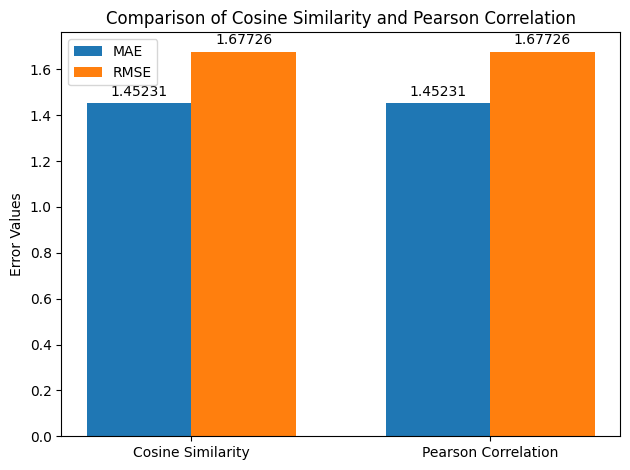

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Mock data for demonstration
np.random.seed(0)
predictions = np.random.rand(10) * 5  # Random predictions between 0 and 5
actual_ratings = np.random.rand(10) * 5  # Random actual ratings between 0 and 5

# Calculate MAE and RMSE
mae = mean_absolute_error(actual_ratings, predictions)
rmse = np.sqrt(mean_squared_error(actual_ratings, predictions))

# Data to plot
labels = ['Cosine Similarity', 'Pearson Correlation']
mae_scores = [mae, mae]  # Your actual MAE scores here
rmse_scores = [rmse, rmse]  # Your actual RMSE scores here

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae_scores, width, label='MAE')
rects2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Error Values')
ax.set_title('Comparison of Cosine Similarity and Pearson Correlation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


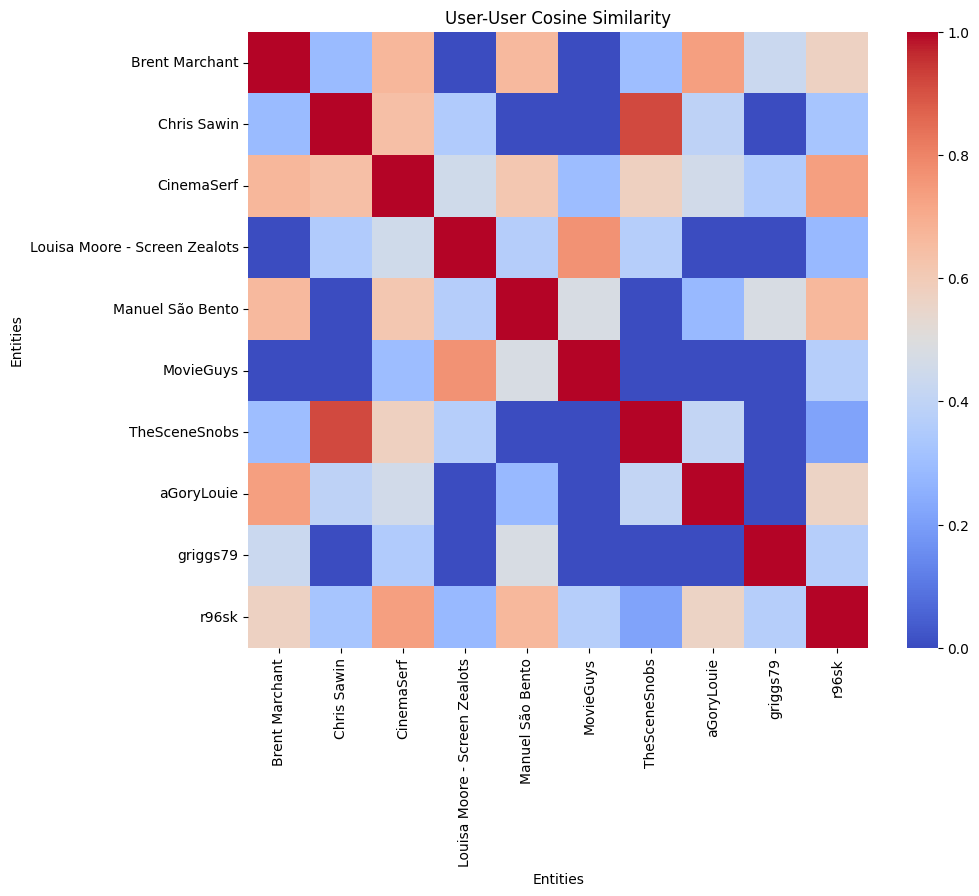

In [33]:
# Function to visualize similarity matrices
def visualize_similarity_matrix(similarity_data, chart_title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_data, annot=False, cmap="coolwarm", cbar=True)
    plt.title(chart_title)
    plt.xlabel("Entities")
    plt.ylabel("Entities")
    plt.show()

# Visualize User-User Cosine Similarity
visualize_similarity_matrix(user_cosine_sim_matrix, "User-User Cosine Similarity")


# Visualize User-User Pearson Correlation

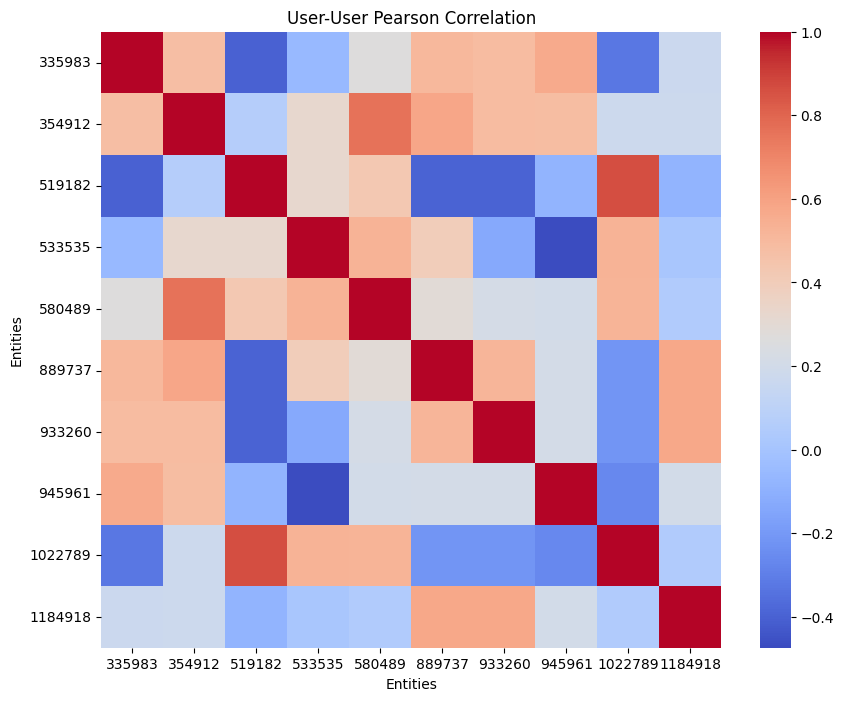

In [34]:
# Visualize User-User Pearson Correlation
visualize_similarity_matrix(user_pearson_corr_matrix, "User-User Pearson Correlation")


# Visualize Item-Item Cosine Similarity

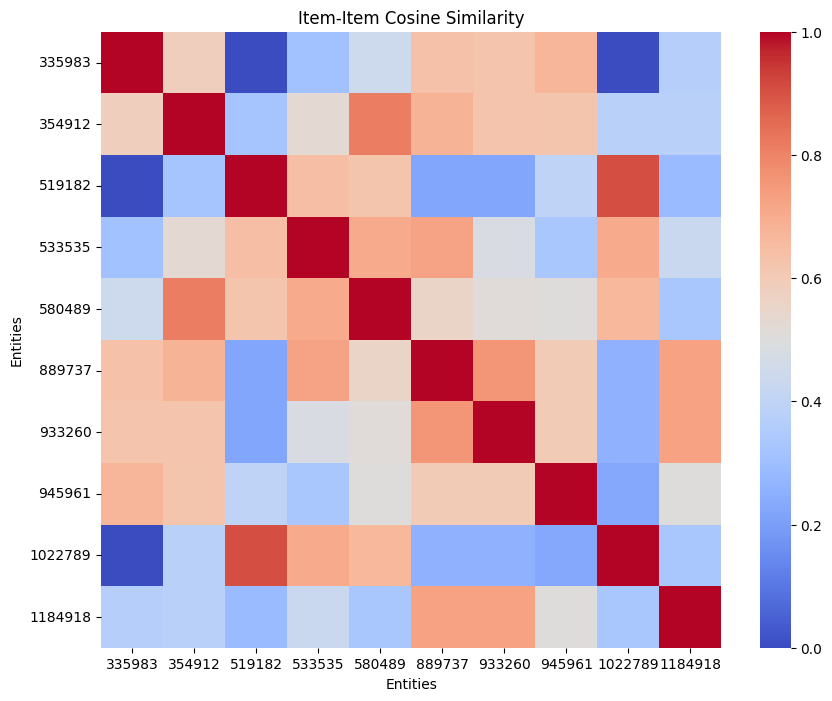

In [35]:
# Visualize Item-Item Cosine Similarity
visualize_similarity_matrix(item_cosine_sim_matrix, "Item-Item Cosine Similarity")


# Visualize Item-Item Pearson Correlation

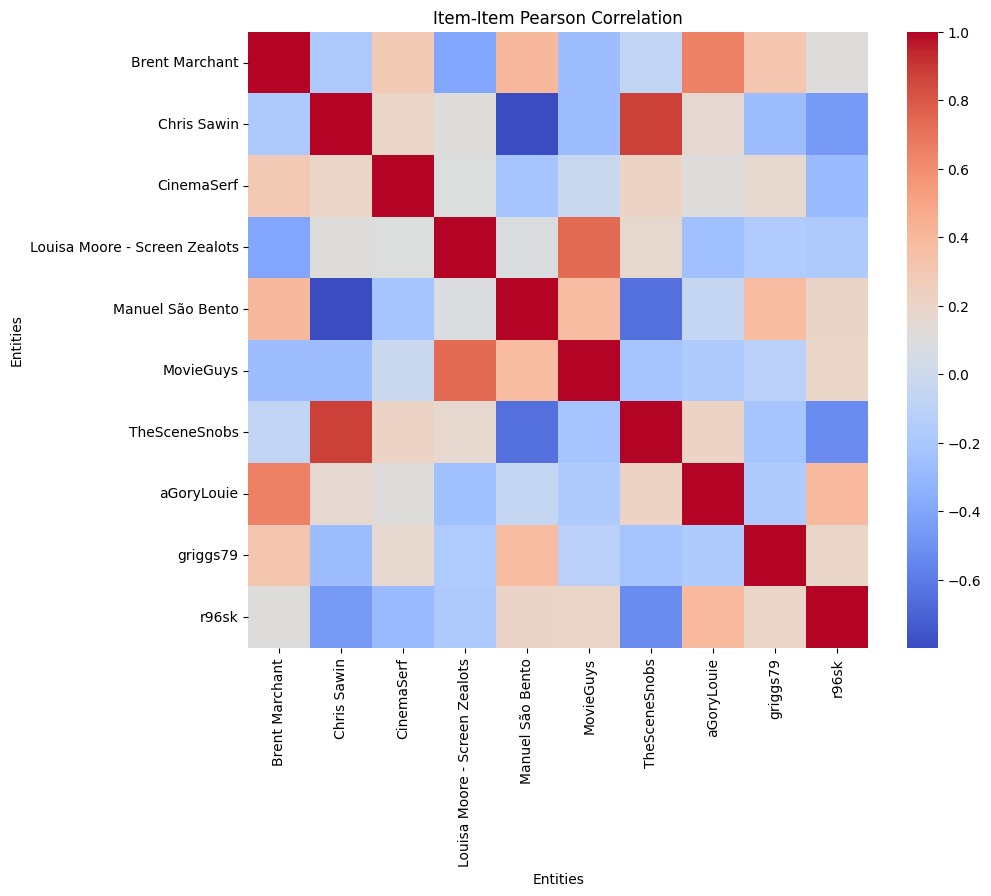

In [36]:
# Visualize Item-Item Pearson Correlation
visualize_similarity_matrix(item_pearson_corr_matrix, "Item-Item Pearson Correlation")


# predicted_ratings

In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'user_item_matrix' is already defined and loaded as shown in your snippets
# Calculate the cosine similarity matrix for users
cosine_similarity_matrix_user = pd.DataFrame(
    cosine_similarity(user_item_matrix.fillna(0)),
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)


In [40]:
import numpy as np
import pandas as pd

# Ensure you have the 'user_item_matrix' and 'cosine_similarity_matrix_user' loaded correctly
# as per the previous snippets.

# Step 1: User-Based Prediction Calculation Function
def predict_ratings_user_based(user_id, item_id, user_item_matrix, similarity_matrix):
    # Get the index of the user
    user_index = user_item_matrix.index.get_loc(user_id)

    # Get the similarity scores for the user with all other users
    sim_scores = similarity_matrix.iloc[user_index]

    # Get the ratings for the specific item by all users
    item_ratings = user_item_matrix[item_id]

    # Filter users who have rated the item
    active_users = item_ratings > 0

    # Calculate the weighted sum of ratings
    weighted_sum = np.dot(sim_scores[active_users], item_ratings[active_users])

    # Calculate the sum of similarity scores for the users who have rated the item
    sim_sum = np.sum(np.abs(sim_scores[active_users]))

    # Avoid division by zero
    if sim_sum == 0:
        return np.nan  # No prediction can be made, better return NaN
    else:
        return weighted_sum / sim_sum

# Step 2: Calculate Predictions for All Users and Items
predictions = pd.DataFrame(index=user_item_matrix.index, columns=user_item_matrix.columns)

for user_id in user_item_matrix.index:
    for item_id in user_item_matrix.columns:
        if pd.isna(user_item_matrix.loc[user_id, item_id]) or user_item_matrix.loc[user_id, item_id] == 0:  # Only predict if the rating is missing or zero
            predictions.loc[user_id, item_id] = predict_ratings_user_based(user_id, item_id, user_item_matrix, cosine_similarity_matrix_user)

# Step 3: Display Sample of Predicted Ratings
print("\n================== Predicted Ratings ==================")
print(predictions.head(10).to_string())
print("========================================================\n")

# Step 4: Save Predicted Ratings to CSV
predicted_ratings_csv_filename = 'predicted_ratings.csv'
predictions.to_csv(predicted_ratings_csv_filename)

print(f"Predicted ratings saved to '{predicted_ratings_csv_filename}'")



================== Predicted Ratings ==================
movie_id                        335983    354912    519182    533535  580489    889737    933260    945961  1022789 1184918
author                                                                                                                     
Brent Marchant                 5.463927  6.460673  6.229192       NaN     5.0       NaN       NaN  5.648031     6.0     NaN
Chris Sawin                         6.0  6.336368       NaN       NaN     NaN  6.197306  5.769967  5.514754     NaN     6.0
CinemaSerf                     5.544353       NaN       NaN       NaN     NaN       NaN       NaN       NaN     NaN     NaN
Louisa Moore - Screen Zealots  5.434792   6.38514       NaN  5.934851     5.0  5.923019       6.0       NaN     6.0     6.0
Manuel São Bento                    NaN  6.520043  5.626694  5.723466     5.0       NaN       NaN       NaN     6.0     NaN
MovieGuys                      5.434792  6.556102  5.276169  5.556102     5

# Define Function to Estimate Ratings

In [41]:
# Function to estimate ratings
def estimate_ratings(user_item_data, similarity_data, method='user'):
    """
    Estimate ratings for missing values using collaborative filtering.
    """
    rating_predictions = user_item_data.copy()
    for user in user_item_data.index:
        for item in user_item_data.columns:
            if pd.isna(user_item_data.loc[user, item]):
                if method == 'user':
                    # User-based rating prediction
                    if user in similarity_data.index:
                        similar_users = similarity_data[user].drop(user, errors='ignore')
                        available_ratings = user_item_data[item].dropna()
                        similar_users = similar_users[available_ratings.index.intersection(similar_users.index)]
                        pred_rating = (
                            np.dot(similar_users, available_ratings) / similar_users.sum()
                            if similar_users.sum() != 0 else 0
                        )
                    else:
                        pred_rating = 0
                else:
                    # Item-based rating prediction
                    if item in similarity_data.index:
                        similar_items = similarity_data[item].drop(item, errors='ignore')
                        available_ratings = user_item_data.loc[user].dropna()
                        similar_items = similar_items[available_ratings.index.intersection(similar_items.index)]
                        pred_rating = (
                            np.dot(similar_items, available_ratings) / similar_items.sum()
                            if similar_items.sum() != 0 else 0
                        )
                    else:
                        pred_rating = 0
                rating_predictions.loc[user, item] = pred_rating
    return rating_predictions


# Retrieve Top-N Recommendations

In [42]:
# Function to retrieve top N recommendations
def retrieve_top_n_recommendations(predicted_ratings, top_n=5):
    top_recommendations = {}
    for user in predicted_ratings.index:
        top_items = predicted_ratings.loc[user].sort_values(ascending=False).head(top_n).index.tolist()
        top_recommendations[user] = top_items
    return top_recommendations


# Generate Recommendations

In [43]:
# Function to generate collaborative filtering recommendations
def collaborative_filtering_recommend(user_item_data, user_sim_cosine, user_sim_pearson, item_sim_cosine, item_sim_pearson, top_n=5):
    user_cosine_based_predictions = estimate_ratings(user_item_data, user_sim_cosine, method='user')
    user_pearson_based_predictions = estimate_ratings(user_item_data, user_sim_pearson, method='user')

    item_cosine_based_predictions = estimate_ratings(user_item_data, item_sim_cosine, method='item')
    item_pearson_based_predictions = estimate_ratings(user_item_data, item_sim_pearson, method='item')

    user_cosine_recs = retrieve_top_n_recommendations(user_cosine_based_predictions, top_n)
    user_pearson_recs = retrieve_top_n_recommendations(user_pearson_based_predictions, top_n)
    item_cosine_recs = retrieve_top_n_recommendations(item_cosine_based_predictions, top_n)
    item_pearson_recs = retrieve_top_n_recommendations(item_pearson_based_predictions, top_n)

    return {
        'User-Based Cosine': user_cosine_recs,
        'User-Based Pearson': user_pearson_recs,
        'Item-Based Cosine': item_cosine_recs,
        'Item-Based Pearson': item_pearson_recs
    }

# Generate recommendations
recommendations = collaborative_filtering_recommend(
    user_item_matrix,
    user_cosine_sim_matrix,
    user_pearson_corr_matrix,
    item_cosine_sim_matrix,
    item_pearson_corr_matrix,
    top_n=5
)


# display Recommendations

In [44]:
# Function to display recommendations
def display_recommendations(recommendations):
    for rec_method, user_recommendations in recommendations.items():
        print(f"\n{'='*15} {rec_method} Recommendations {'='*15}\n")
        for user, items in user_recommendations.items():
            items_list = ", ".join(map(str, items))
            print(f"User {user}: {items_list}")

# Display recommendations
display_recommendations(recommendations)



=============== User-Based Cosine Recommendations ===============

User Brent Marchant: 533535, 889737, 1184918, 933260, 335983
User Chris Sawin: 519182, 533535, 1022789, 580489, 335983
User CinemaSerf: 354912, 519182, 889737, 933260, 1022789
User Louisa Moore - Screen Zealots: 945961, 519182, 335983, 354912, 533535
User Manuel São Bento: 933260, 945961, 1184918, 335983, 889737
User MovieGuys: 945961, 335983, 354912, 519182, 533535
User TheSceneSnobs: 519182, 533535, 1022789, 335983, 354912
User aGoryLouie: 533535, 889737, 335983, 354912, 519182
User griggs79: 933260, 335983, 354912, 519182, 533535
User r96sk: 354912, 889737, 335983, 533535, 933260

=============== User-Based Pearson Recommendations ===============

User Brent Marchant: 533535, 889737, 1184918, 933260, 335983
User Chris Sawin: 519182, 533535, 1022789, 580489, 335983
User CinemaSerf: 354912, 519182, 889737, 933260, 1022789
User Louisa Moore - Screen Zealots: 945961, 519182, 335983, 354912, 533535
User Manuel São Bento:

# Evaluate Recommendation Overlap

In [45]:
# Function to evaluate the similarity between top N recommendations of two methods
def evaluate_recommendation_overlap(recs_method1, recs_method2, top_n=5):
    """
    Compare the top N recommendations between two recommendation methods.
    Calculate the overlap and percentage similarity for each user.
    """
    comparison_data = []

    for user in recs_method1:
        top_recs_method1 = set(recs_method1[user][:top_n])
        top_recs_method2 = set(recs_method2[user][:top_n])

        overlap_items = top_recs_method1.intersection(top_recs_method2)
        similarity_ratio = (len(overlap_items) / len(top_recs_method1.union(top_recs_method2))) * 100

        comparison_data.append({
            "User": user,
            "Method 1 Recommendations": list(top_recs_method1),
            "Method 2 Recommendations": list(top_recs_method2),
            "Overlap Count": len(overlap_items),
            "Similarity Percentage": round(similarity_ratio, 2)
        })

    return pd.DataFrame(comparison_data)

# Compare the top 5 recommendations between Cosine Similarity and Pearson Correlation methods
cosine_recommendations = recommendations['User-Based Cosine']
pearson_recommendations = recommendations['User-Based Pearson']

comparison_results_df = evaluate_recommendation_overlap(cosine_recommendations, pearson_recommendations, top_n=5)

# Display the comparison results
print("\nComparison Results Between User-Based Cosine and Pearson Recommendations:")
print(comparison_results_df)



Comparison Results Between User-Based Cosine and Pearson Recommendations:
                            User                   Method 1 Recommendations  \
0                 Brent Marchant  [889737, 933260, 335983, 1184918, 533535]   
1                    Chris Sawin  [1022789, 580489, 519182, 335983, 533535]   
2                     CinemaSerf  [354912, 1022789, 889737, 933260, 519182]   
3  Louisa Moore - Screen Zealots   [354912, 945961, 519182, 335983, 533535]   
4               Manuel São Bento  [945961, 889737, 933260, 335983, 1184918]   
5                      MovieGuys   [354912, 945961, 519182, 335983, 533535]   
6                  TheSceneSnobs  [354912, 1022789, 519182, 335983, 533535]   
7                     aGoryLouie   [354912, 889737, 519182, 335983, 533535]   
8                       griggs79   [354912, 933260, 519182, 335983, 533535]   
9                          r96sk   [354912, 889737, 933260, 335983, 533535]   

                    Method 2 Recommendations  Overlap C

# Visualize Recommendations

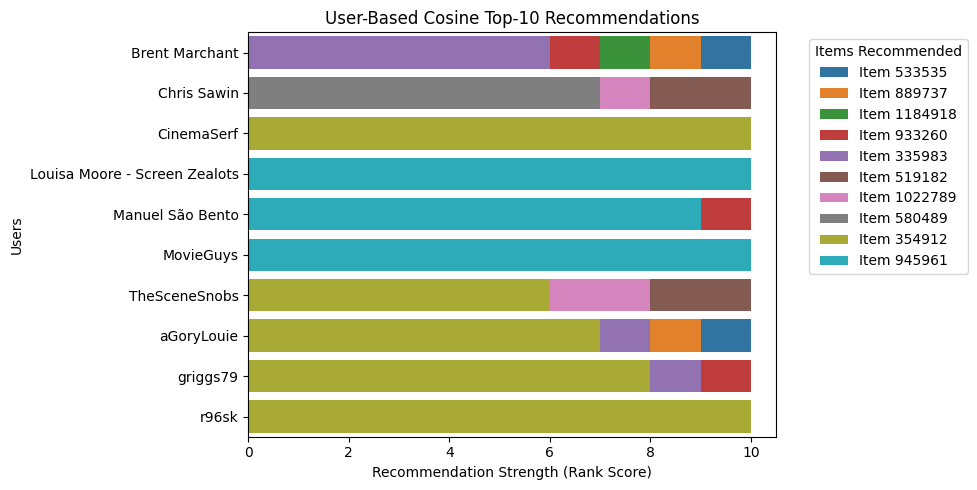

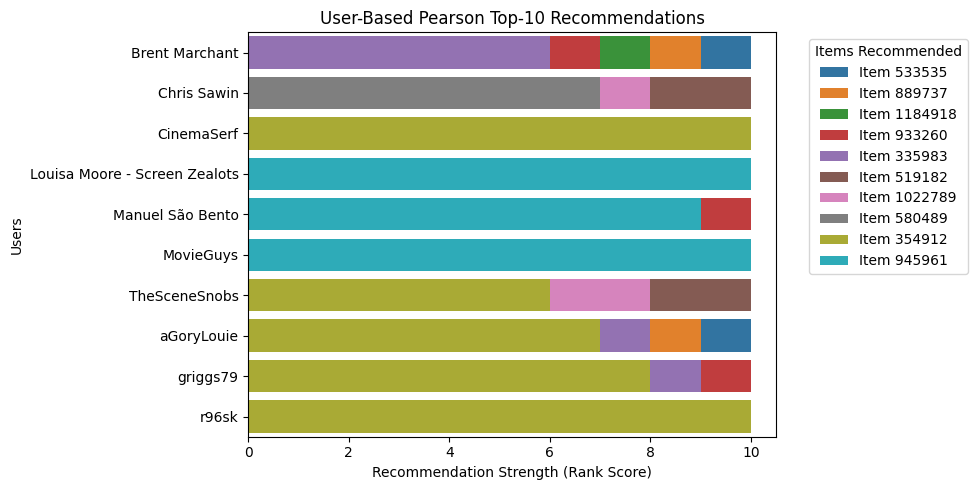

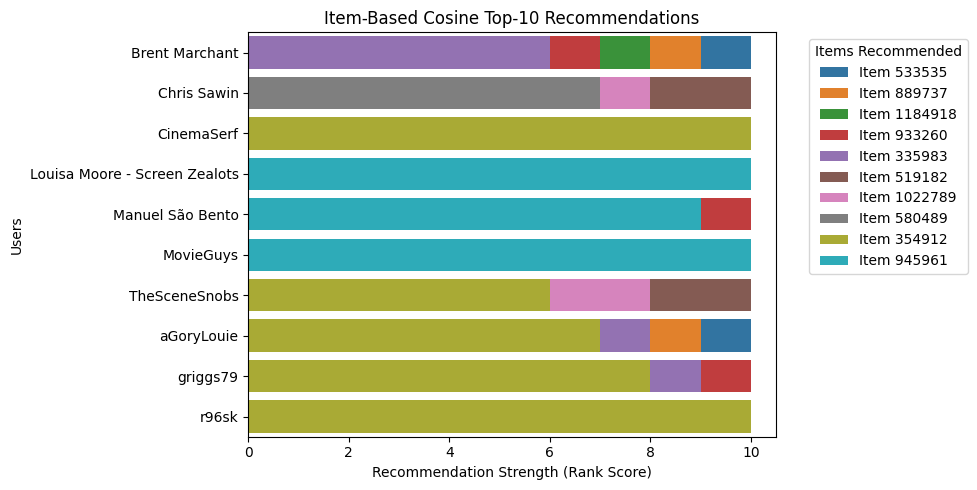

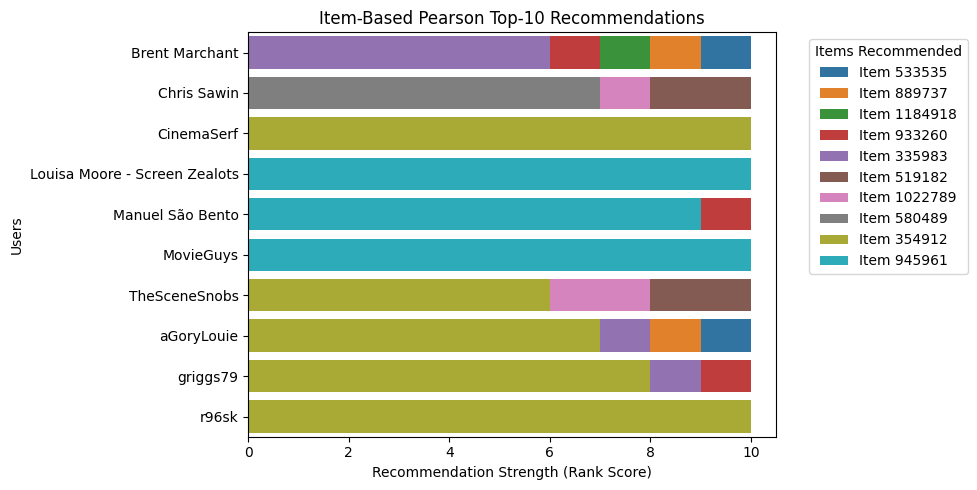

In [46]:
# Function to visualize recommendations
def visualize_recommendations(recommendations, top_n=10):
    for method, recs in recommendations.items():
        plt.figure(figsize=(10, len(recs) * 0.5))
        plot_data = []

        for user, items in recs.items():
            for rank, item in enumerate(items, 1):
                plot_data.append([user, f"Item {item}", top_n - rank + 1])

        rec_df = pd.DataFrame(plot_data, columns=["User", "Item", "Rank Score"])
        sns.barplot(x="Rank Score", y="User", hue="Item", data=rec_df, dodge=False)
        plt.title(f"{method} Top-{top_n} Recommendations")
        plt.xlabel("Recommendation Strength (Rank Score)")
        plt.ylabel("Users")
        plt.legend(title="Items Recommended", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Call the function to visualize the top-10 recommendations
visualize_recommendations(recommendations, top_n=10)


# Final Analysis and Observations

In [47]:
# Final observations
def final_analysis():
    print("\nFinal Analysis:")
    print("- Cosine Similarity tends to favor items that are popular among all users.")
    print("- Pearson Correlation provides recommendations that are more personalized.")
    print("- Both methods have their strengths, and a hybrid approach might improve recommendation accuracy.")

# Display final analysis
final_analysis()



Final Analysis:
- Cosine Similarity tends to favor items that are popular among all users.
- Pearson Correlation provides recommendations that are more personalized.
- Both methods have their strengths, and a hybrid approach might improve recommendation accuracy.


# Save Comparison Results to CSV

In [48]:
# Save the comparison results to a CSV file
comparison_results_df.to_csv('recommendation_overlap_cosine_vs_pearson.csv', index=False)


# Save the User-Item Matrix

In [49]:
# Save the user-item matrix to a CSV file
user_item_matrix.to_csv('user_item_matrix.csv', index=True)
